In [1]:
# Standard modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import plotly.graph_objects as go
import chart_studio.plotly as py
from modules.network import get_degree

# Set up default colors
colors=[*mc.TABLEAU_COLORS.values()]

# Setup matpltlib visualization
%matplotlib inline

# Dataset creation

In [2]:
# Define periods under analysis
years = [2017, 2018]

In [3]:
# Load vocabularies for words
w2i = np.load('data/edges_w2i.npy', allow_pickle=True).item()
i2w = np.load('data/edges_i2w.npy', allow_pickle=True).item()

In [4]:
# Retrieve edges
edges = pd.read_csv('data/database/edges.csv').sort_values(by='weight', ascending=False)
edges.head()

node_x  node_y  weight  year
74462    2466     954     123  2018
44227     954    2466     123  2018
75031    2466    2466      90  2018
63536    1928    2466      73  2018
74847    2466    1928      73  2018

In [5]:
# Remove edges whose weight is under a predefined thershold
threshold = 1  # Threshold on minimum weights currently set to 1
edges = edges[edges.weight > threshold]  # Remove edges whose weight is under a threshold

In [6]:
# Split edges for each year
edges = {y: edges[(edges.year == y) & (edges.weight > 1)][['node_x', 'node_y', 'weight']] for y in years}

## Edges distribution

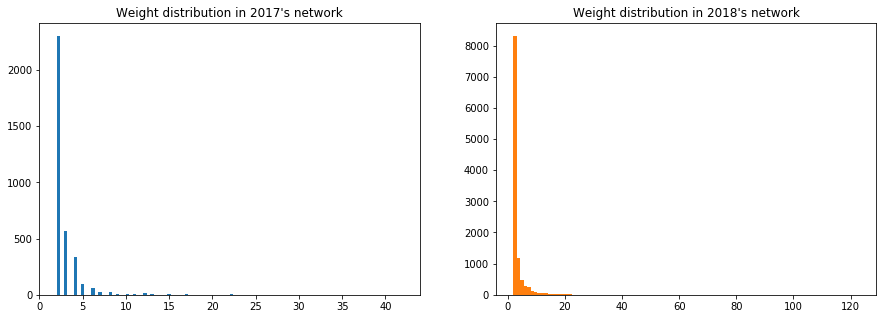

In [7]:
# Show edges distribution
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, y in enumerate(years):
    _ = axs[i].set_title('Weight distribution in {:d}\'s network'.format(y))
    _ = axs[i].hist(edges[y].weight, bins=100, color=colors[i])

# Network creation

In [8]:
# Create the networks object
network = dict()

for y in years:
    # Create network
    network[y] = nx.from_pandas_edgelist(
        edges[y], source='node_x', target='node_y', edge_attr=True, create_using=nx.Graph
    )
    
    # Compute connected components
    cc = sorted(nx.connected_components(network[y]), key=len, reverse=True)
    gc = cc[0]  # Get giant component
    
    # Keep only giant component network
    network[y] = nx.induced_subgraph(network[y], gc)

## Network visualization

In [9]:
# Compute a layout for each network using a spring layout
layout = {y: nx.spring_layout(network[y], iterations=200) for y in years}

### Static visualization

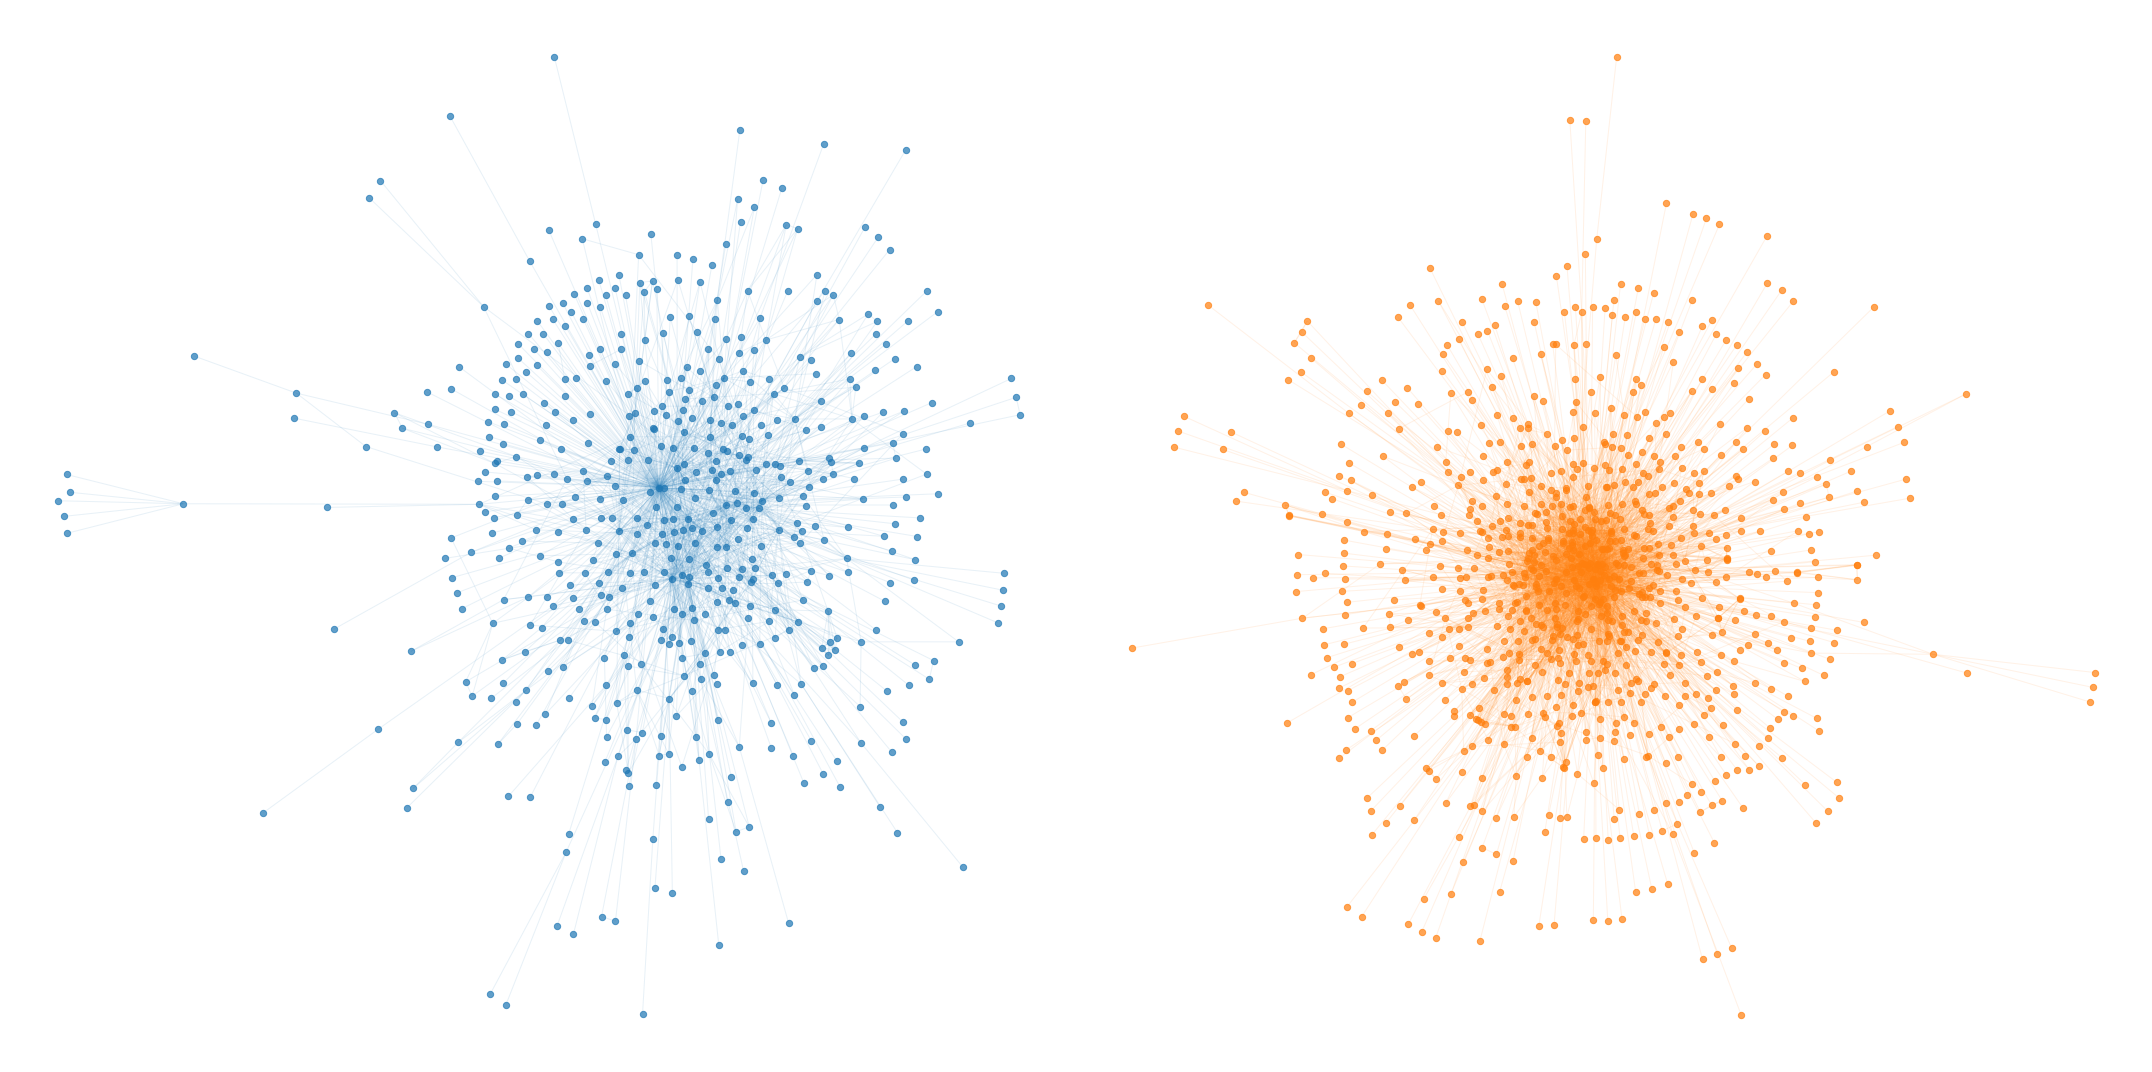

In [10]:
# Plot networks
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
for i, y in enumerate(years):
    # Plot nodes
    _ = nx.draw_networkx_nodes(network[y], pos=layout[y], node_size=40, alpha=0.7, node_color=colors[i], ax=axs[i])
    # Plot edges
    _ = nx.draw_networkx_edges(network[y], pos=layout[y], style='solid', alpha=0.1, edge_color=colors[i], ax=axs[i])
    # Remove border
    _ = axs[i].axis('off')
_ = plt.tight_layout()
_ = plt.show()

### Interactive visualization

In [38]:
class interactive_network_plot:
    
    # Constructor
    def __init__(self, network, layout):
        # Store either network and layout
        self.network = network
        self.layout = layout
    
    # Retrieve nodes position
    def get_nodes(self, nodes=None):
        nodes = self.network.nodes() if nodes is None else nodes
        nodes_x, nodes_y = [], []
        for node in nodes:
            x, y = self.layout[node]
            nodes_x.append(x)
            nodes_y.append(y)
        return nodes_x, nodes_y
    
    # Retrieve edges position
    def get_edges(self):
        # Define edges container
        edges_x, edges_y = [], []
        # Fill edges positions
        for edge in self.network.edges():
            x0, y0 = self.layout[edge[0]]
            x1, y1 = self.layout[edge[1]]
            edges_x += [x0, x1, None]
            edges_y += [y0, y1, None]
        # Return edges
        return edges_x, edges_y
    
    # Get trace for edges
    def draw_edges(self, settings={}):
        # Retireve edges positions
        edges_x, edges_y = self.get_edges()
        # Define default settings
        defaults = {
            'line': {'width': 0.5, 'color':'black'},
            'hoverinfo': 'none',
            'mode': 'lines',
            'opacity': 0.3
        }
        # Merge settings
        settings = {**defaults, **settings}
        # Update edges positions
        settings['x'], settings['y'] = edges_x, edges_y
        # Return plotly trace
        return go.Scatter(**settings)
    
    # Get trace for nodes
    def draw_nodes(self, nodes=None, settings={}, color=[], text=[]):
        # Retrieve nodes positions
        nodes_x, nodes_y = self.get_nodes(nodes)
        # Define default settings
        defaults = {
            'mode': 'markers',
            'hoverinfo': 'text',
            'marker': {
                'showscale': True,
                'colorscale': 'Viridis',
                'reversescale': False,
                'size': 10,
                'colorbar': {
                    'thickness': 10,
                    'title': 'Node connections',
                    'xanchor': 'left',
                    'titleside': 'right'
                },
                'line_width': 1
            }
        }
        # Merge settings
        settings = {**defaults, **settings}
        settings['text'] = text
        settings['marker']['color'] = color
        # Substitute x and y with edges
        settings['x'], settings['y'] = nodes_x, nodes_y
        # Return plotly trace
        return go.Scatter(**settings)
        
    # Draw the whole network
    def draw(self, edge_trace, node_traces, settings={}):
        # Define default settings of the figure
        defaults = {
            'titlefont_size': 16,
            'showlegend': False,
            'hovermode': 'closest',
            'margin': {'b': 20, 'l': 5, 'r': 5, 't': 40},
            'xaxis': {'showgrid': False, 'zeroline': False, 'showticklabels':False},
            'yaxis': {'showgrid': False, 'zeroline': False, 'showticklabels': False}
        }
        # Merge default settings with user specified ones
        settings = {**defaults, **settings}
        # Make the plot
        return go.Figure(data=[edge_trace] + node_traces, layout=go.Layout(**settings))

In [39]:
# Create plots
plots = {}

for y in years:
    # Retrieve network and layout for current year
    netplot = interactive_network_plot(network[y], layout[y])
    # Retrieve degrees
    degrees = {node: degree for node, degree in netplot.network.degree(weight='weight')}
    # Initialize plot
    edge_trace = netplot.draw_edges()
    node_trace = netplot.draw_nodes(
        # Define text for nodes
        text = ['lemma: {:s}<br>'.format(str(i2w[node])) +
                'degree: {:d}'.format(degrees[node]) 
                for node in netplot.network.nodes()],
        # Define colors for nodes
        color = np.log10([degrees[node] for node in netplot.network.nodes()]))
    # Create plot
    plots[y] = netplot.draw(edge_trace, [node_trace], settings={
        'title': '{:d}\'s network'.format(y)
    })

#### 2017's network

In [40]:
plots[2017].show()

#### 2018's network

In [41]:
plots[2018].show()

### Colouring by POS tag

In [62]:
# Create plots
plots = {}

# Define colouring by pos tag
pos_patches = {
    'N': (colors[0], 'Noun'),  # Noun
    'V': (colors[1], 'Verb'),  # Verb
    'A': (colors[2], 'Adjective'),  # Adjective
    'R': (colors[3], 'Adverb')   # Adverb
}

for y in years:
    # Retrieve network and layout for current year
    netplot = interactive_network_plot(network[y], layout[y])
    # Get edges trace
    edge_trace = netplot.draw_edges(settings={
        'showlegend': False
    })
    
    # Retrieve degrees of each node
    degrees = {node: degree for node, degree in netplot.network.degree(weight='weight')}
    
    # Initialize node traces container (one list for every available tag)
    node_traces = {pos_tag: [] for pos_tag in pos_patches.keys()}
    # Fill lists
    for node in netplot.network.nodes():
        # Add node to the respective pos tag conatiner
        node_traces[i2w[node][1]].append(node)
        
    # Draw each node trace
    for pos_tag in node_traces.keys():
        # Fill node traces according to plotly standards
        node_traces[pos_tag] = netplot.draw_nodes(
            # Substitute nodes with traces containing them
            nodes = node_traces[pos_tag],
            # Define settings for current trace
            settings={
                'marker': {'size': 10},
                # Set the name to be the one of the current pos tag
                'name': pos_patches[pos_tag][1],
                # Set legend visualization
                'showlegend': True
            },
            # Define text for nodes
            text = ['lemma: {:s}<br>'.format(str(i2w[node])) +
                    'degree: {:d}'.format(degrees[node]) 
                    for node in node_traces[pos_tag]],
            # Define marker color
            color = pos_patches[pos_tag][0])
    
    # Turn dictionaries to list (allow concatenation)
    node_traces = list(node_traces.values())
    
    # Create plot
    plots[y] = netplot.draw(edge_trace, node_traces, settings={
        'title': '{:d}\'s network'.format(y),
        'showlegend': True
    })

In [63]:
plots[2017].show()

In [64]:
plots[2018].show()